In [782]:
import numpy as np
import numpy.linalg as la
import matplotlib
from utils import linesearch
import matplotlib.pyplot as plt
from pymanopt.manifolds import Grassmann, Sphere
import torch
import random
import time
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

%config InlineBackend.figure_format = 'svg'

In [783]:
t1 = time.time()
d = 1000
n = int(1.01*d)
p = 1
np.random.seed(0)
A = np.random.randn(d,n)/np.sqrt(n)
H = np.dot(A,A.T)
eigenvalues, eigenvectors = la.eig(H)
max_eig = np.max(eigenvalues)
min_eig = np.min(eigenvalues)
x_sol = np.reshape(eigenvectors[:, np.argmax(eigenvalues)], (-1,1))

# Projection matrices onto a two dimensional subspace
M = Sphere(d)
def cost(X): return 0.5*la.norm(A - np.dot(np.dot(X,X.T),A),"fro") ** 2
# def egrad(X): return -2*np.dot(H-np.dot(np.dot(X,X.T),H),X)
def cost(X): return -0.5*np.trace(np.dot(H,np.dot(X,X.T)))
def egrad(X): return -np.dot(H,X)
def grad(X): return M.egrad2rgrad(X,egrad(X))
def retr(X): return M.retr(X,0*X)
def exp(X,U): return M.exp(X,U)
def rexp(X,U): return retr(M.exp(X,U))
def log(X,Y): return M.log(X,Y)
def dist(X,Y): return M.dist(X,Y)
def transp(X,Y,U): return M.transp(X,Y,U)

#parameters
N = 1000
mu = min_eig
L = max_eig
h = 1/L
line_search_iterations = 50


#initialization
x0 = np.zeros((d,p))
#starting position
np.random.seed(0)
x0=retr(10*np.random.randn(d,p))

    
#init for riemannian gradient descent
x1 = np.zeros((d,p,N))
f1 = np.zeros((N,))
x1[:,:,0] = x0
f1[0] = cost(x0)-cost(x_sol)

#init for riemannian gd acc
x2 = np.zeros((d,p,N))
y2 = np.zeros((d,p,N))
v2 = np.zeros((d,p,N))
a2 = np.zeros((N,))
A2 = np.zeros((N,))
f2 = np.zeros((N,))
beta2 = np.zeros((N,))
x2[:,:,0] = x0
v2[:,:,0] = x0
f2[0] = cost(x0)-cost(x_sol)


0.8306500911712646


In [788]:
#methods "without" tuning
for k in range(N-1):
    x1[:,:,k+1] = exp(x1[:,:,k],-h*grad(x1[:,:,k]))
    t1 = time.time()
    f1[k+1] = cost(x1[:,:,k+1])-cost(x_sol)
    t2 = time.time()
    print(t2-t1)


for k in range(N-1):
    beta2[k] = linesearch(v2[:,:,k],x2[:,:,k],log,exp,cost,line_search_iterations)
    y2[:,:,k] = exp(v2[:,:,k], beta2[k]* log(v2[:,:,k],x2[:,:,k]))
    x2[:,:,k+1] = exp(y2[:,:,k],-h*grad(y2[:,:,k]))
    a2[k+1] = np.max(np.roots(np.array([1, -h, -h*A2[k]])))
    A2[k+1] = A2[k]+a2[k+1]
    v2[:,:,k+1] = rexp(v2[:,:,k],-a2[k+1]*transp(y2[:,:,k],v2[:,:,k],grad(y2[:,:,k])))
    f2[k+1] = cost(x2[:,:,k+1])-cost(x_sol);

0.08976411819458008
0.05583906173706055
0.048714399337768555
0.04803299903869629
0.0491640567779541
0.06389498710632324
0.04849672317504883
0.04818606376647949
0.05642986297607422
0.05956578254699707
0.05305814743041992
0.0514979362487793
0.05817699432373047
0.061543941497802734
0.0488739013671875
0.04850912094116211
0.052971839904785156
0.05867290496826172
0.05408477783203125
0.0525357723236084
0.07007217407226562
0.07297205924987793
0.052062034606933594
0.05369305610656738
0.06619024276733398
0.05246424674987793
0.05262303352355957
0.06099367141723633
0.05525493621826172
0.06619501113891602
0.0565030574798584
0.05127120018005371
0.06352901458740234
0.056279897689819336
0.05375170707702637
0.05779623985290527


KeyboardInterrupt: 

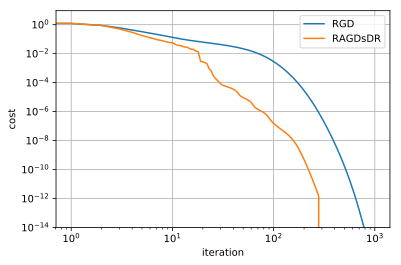

In [781]:
fig, ax = plt.subplots()
ax.loglog(range(N), f1,label='RGD')
ax.loglog(range(N), f2,label='RAGDsDR')
ax.set(xlabel='iteration', ylabel='cost')
ax.grid()
ax.legend()
ax.set_ylim(bottom=1e-14)
plt.show()